In [1]:
# Загружаем нобходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
14# Предсказываемое значение
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [5]:
# Получим основную информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

У признака shot_made_flag отсутствует часть значений. По условиям задания эти данные удалены с целью осуществления дальнейшего прогноза этих значений. Остальные значения присутствуют в полном объёме.  
Для дальнейшеё работы оставим только те данные, значения целевой переменной которых нам известны.

In [6]:
# Удаляем данные, не содржащие сведения о целевой переменной
new_data = data.copy()
new_data = new_data.dropna()

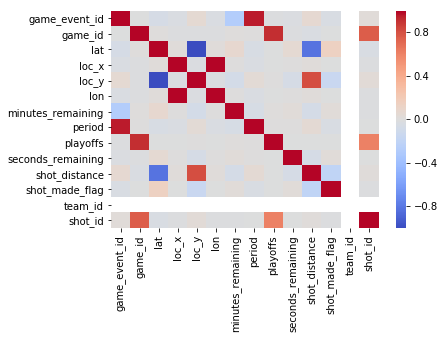

In [7]:
# Построим тепловую карту для визуализации корреляционных матриц
sns.heatmap(new_data.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Из полученных данных видим, что lon и loc_x, game_event_id и game_id, period и playoffs, соответственно, хорошо скоррелированы между собой. Следовательно, данные признаки являются коллинеарными.  Машинном обучении это приводит к снижению производительности обобщения данных из-за высокой дисперсии и меньшей интерпретируемости модели. Удалим коллинеарные признаки.

In [8]:
new_data = new_data.drop (['loc_x', 'game_event_id', 'period' ], 1)
new_data.head()

,action_type,combined_shot_type,game_id,lat,loc_y,lon,minutes_remaining,playoffs,season,seconds_remaining,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,20000012,34.0443,0,-118.4268,10,0,2000-01,22,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,20000012,33.9093,135,-118.3708,7,0,2000-01,45,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,20000012,33.8693,175,-118.1318,6,0,2000-01,52,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,20000012,34.0443,0,-118.2698,6,0,2000-01,19,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,20000012,34.0553,-11,-118.4148,9,0,2000-01,32,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [9]:
# Получим основные статистические данные по датасету
new_data.describe()

,game_id,lat,loc_y,lon,minutes_remaining,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,2.474109e+07,33.953043,91.257345,-118.262652,4.886796,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,7.738108e+06,0.088152,88.152106,0.110073,3.452475,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000001e+07,33.253300,-44.000000,-118.519800,0.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,2.050006e+07,33.884300,4.000000,-118.336800,2.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,2.090034e+07,33.970300,74.000000,-118.269800,5.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,2.960027e+07,34.040300,160.000000,-118.175800,8.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,4.990009e+07,34.088300,791.000000,-118.021800,11.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


Данные, которые с увернностью можно назвать выбросами,отсутствуют.

Рассмотрим категориальные признаки.  

In [10]:
# Определим распределение заполнения колонки action_type
new_data['action_type'].value_counts()

Jump Shot                          15836
Layup Shot                          2154
Driving Layup Shot                  1628
Turnaround Jump Shot                 891
Fadeaway Jump Shot                   872
Running Jump Shot                    779
Pullup Jump shot                     402
Turnaround Fadeaway shot             366
Slam Dunk Shot                       334
Reverse Layup Shot                   333
Jump Bank Shot                       289
Driving Dunk Shot                    257
Dunk Shot                            217
Tip Shot                             151
Step Back Jump shot                  106
Alley Oop Dunk Shot                   95
Floating Jump shot                    93
Driving Reverse Layup Shot            83
Hook Shot                             73
Driving Finger Roll Shot              68
Alley Oop Layup shot                  67
Reverse Dunk Shot                     61
Driving Finger Roll Layup Shot        59
Turnaround Bank shot                  58
Running Layup Sh

In [11]:
# Определим распределение заполнения колонки combined_shot_type
new_data['combined_shot_type'].value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

In [12]:
# Определим распределение заполнения колонки season
new_data['season'].value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

In [13]:
# Определим распределение заполнения колонки shot_type
new_data['shot_type'].value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

In [14]:
# Определим распределение заполнения колонки shot_zone_area
new_data['shot_zone_area'].value_counts()

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64

In [15]:
# Определим распределение заполнения колонки shot_zone_basic
new_data['shot_zone_basic'].value_counts()

Mid-Range                10532
Restricted Area           5932
Above the Break 3         4720
In The Paint (Non-RA)     3880
Right Corner 3             333
Left Corner 3              240
Backcourt                   60
Name: shot_zone_basic, dtype: int64

In [16]:
# Определим распределение заполнения колонки shot_zone_range
new_data['shot_zone_range'].value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

In [17]:
# Определим распределение заполнения колонки team_name 
new_data['team_name'].value_counts()

Los Angeles Lakers    25697
Name: team_name, dtype: int64

In [18]:
# Определим распределение заполнения колонки game_date
new_data['game_date'].value_counts()

2016-04-13    43
2007-03-30    41
2006-01-22    39
2002-11-07    39
2008-01-14    37
              ..
1998-03-16     1
1997-02-21     1
1996-11-29     1
1996-11-03     1
1996-12-10     1
Name: game_date, Length: 1558, dtype: int64

In [19]:
# Определим распределение заполнения колонки matchup
new_data['matchup'].value_counts()

LAL @ SAS      853
LAL vs. SAS    765
LAL @ SAC      751
LAL @ PHX      751
LAL vs. HOU    722
              ... 
LAL @ PHO       29
LAL vs. NOP     21
LAL vs. SAN     20
LAL @ UTH       15
LAL vs. BKN     13
Name: matchup, Length: 74, dtype: int64

In [20]:
# Определим распределение заполнения колонки opponent
new_data['opponent'].value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

Принаки opponent и matchup аналогичны друг другу. Удалим один из этих признаков.  
Выбор признака, который удаляем основан на том, что в matchup для одной и той же команды используются различные обозначения, что может привести к ошибкам.

In [21]:
# Удаляем признак matchup
new_data = new_data.drop ('matchup', 1)

Признак team_name содержит только одно значение, следовательно, он неинформативен и его можно удалить.

In [22]:
# Удаляем признак team_name
new_data = new_data.drop ('team_name', 1)

Признаки action_type, combined_shot_type, shot_zone_area, shot_zone_basic и opponent невозможно отсортировать от большего к меньшему. Следовательно, воспользуемся get_dummies.

In [23]:
new_data = pd.get_dummies(new_data, 
                         columns = ['action_type', 'combined_shot_type', 'shot_zone_area', 'shot_zone_basic', 'opponent'])
new_data.head()

,game_id,lat,loc_y,lon,minutes_remaining,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,20000012,34.0443,0,-118.4268,10,0,2000-01,22,15,0.0,...,0,0,1,0,0,0,0,0,0,0
2,20000012,33.9093,135,-118.3708,7,0,2000-01,45,16,1.0,...,0,0,1,0,0,0,0,0,0,0
3,20000012,33.8693,175,-118.1318,6,0,2000-01,52,22,0.0,...,0,0,1,0,0,0,0,0,0,0
4,20000012,34.0443,0,-118.2698,6,0,2000-01,19,0,1.0,...,0,0,1,0,0,0,0,0,0,0
5,20000012,34.0553,-11,-118.4148,9,0,2000-01,32,14,0.0,...,0,0,1,0,0,0,0,0,0,0


Признаки season и game_date являются схожими. Второй признак является более расширенным. Оставим из данных признаков тот признак, который является своеобразной группировкой признаков.

In [24]:
# Удаляем признак game_date
new_data = new_data.drop('game_date', 1)

У признака shot_type есть два типа значений. Переведём этот признак в значения 0 и 1.

In [25]:
le = LabelEncoder()
le.fit(new_data['shot_type'])
new_data['shot_type'] = le.transform(new_data['shot_type'])
new_data.head()

,game_id,lat,loc_y,lon,minutes_remaining,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,20000012,34.0443,0,-118.4268,10,0,2000-01,22,15,0.0,...,0,0,1,0,0,0,0,0,0,0
2,20000012,33.9093,135,-118.3708,7,0,2000-01,45,16,1.0,...,0,0,1,0,0,0,0,0,0,0
3,20000012,33.8693,175,-118.1318,6,0,2000-01,52,22,0.0,...,0,0,1,0,0,0,0,0,0,0
4,20000012,34.0443,0,-118.2698,6,0,2000-01,19,0,1.0,...,0,0,1,0,0,0,0,0,0,0
5,20000012,34.0553,-11,-118.4148,9,0,2000-01,32,14,0.0,...,0,0,1,0,0,0,0,0,0,0


Признаки season и shot_zone_range переведём в числовые значения.

In [26]:
le_1 = LabelEncoder()
le_2 = LabelEncoder()
le_1.fit(new_data['season'])
le_2.fit(new_data['shot_zone_range'])
new_data['season'] = le_1.transform(new_data['season'])
new_data['shot_zone_range'] = le_2.transform(new_data['shot_zone_range'])
new_data.head()

,game_id,lat,loc_y,lon,minutes_remaining,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,20000012,34.0443,0,-118.4268,10,0,4,22,15,0.0,...,0,0,1,0,0,0,0,0,0,0
2,20000012,33.9093,135,-118.3708,7,0,4,45,16,1.0,...,0,0,1,0,0,0,0,0,0,0
3,20000012,33.8693,175,-118.1318,6,0,4,52,22,0.0,...,0,0,1,0,0,0,0,0,0,0
4,20000012,34.0443,0,-118.2698,6,0,4,19,0,1.0,...,0,0,1,0,0,0,0,0,0,0
5,20000012,34.0553,-11,-118.4148,9,0,4,32,14,0.0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
# Получим основную информацию о датасете после обработки категориальных признаков
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Columns: 121 entries, game_id to opponent_WAS
dtypes: float64(3), int32(3), int64(8), uint8(107)
memory usage: 5.3 MB


Категориальные признаки обработаны в полном объёме.

In [28]:
# Определим распределение заполнения предсказымаевого признака
new_data[target].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

In [29]:
# Разделим наши данные на обучающие и тестовые
X = new_data.drop(target, 1)
y = new_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Предсказываемое значение состоит из двух значений. Следовательно, наша задача - задача классификации.

In [30]:
# Используем логистическу регрессию
model_1 = LogisticRegression() 
model_1.fit(X_train, y_train) # Обучаем на тренировочной части датасета
predictions_1 = model_1.predict(X_test) # Строим предсказание
print(f'Качество для тренировочных данных - {model_1.score(X_train, y_train)}')
print(f'Качество для тестовых данных - {model_1.score(X_test,y_test)}')

Качество для тренировочных данных - 0.5531216990048369
Качество для тестовых данных - 0.5555123216601816


In [31]:
# Используем регрессию LASSO
model_2 = LassoCV()
model_2.fit(X_train, y_train) # Обучаем на тренировочной части датасета
predictions_2 = model_2.predict(X_test) # Строим предсказание
print(f'Качество для тренировочных данных - {model_2.score(X_train, y_train)}')
print(f'Качество для тестовых данных - {model_2.score(X_test,y_test)}')

Качество для тренировочных данных - 0.0004214119177033959
Качество для тестовых данных - -0.00017895504916132232


In [32]:
# Используем Ridge (с встроеной регуляризацией)
model_3 = RidgeClassifier()
model_3.fit(X_train, y_train) # Обучаем на тренировочной части датасета
predictions_3 = model_3.predict(X_test) # Строим предсказание
print(f'Качество для тренировочных данных - {model_3.score(X_train, y_train)}')
print(f'Качество для тестовых данных - {model_3.score(X_test,y_test)}')

Качество для тренировочных данных - 0.6837716128314895
Качество для тестовых данных - 0.6773022049286641


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.87761e-19): result may not be accurate.
  overwrite_a=True).T


In [33]:
# Строим сравнительную таблицу коэффициентов
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame({'LogisticRegression' : model_1.coef_[0],
                        'LassoCV' : model_2.coef_, 
                        'RidgeClassifier' : model_3.coef_[0]}))

     LogisticRegression       LassoCV  RidgeClassifier
0         -1.990996e-09  3.564898e-10    -7.915693e-09
1          4.590186e-16  0.000000e+00    -1.289539e-07
2         -4.611711e-13 -0.000000e+00     1.289591e-04
3         -3.332303e-18 -0.000000e+00    -1.963475e-01
4          3.465092e-15  0.000000e+00     6.740529e-03
5         -2.702335e-17  0.000000e+00     1.591717e-01
6         -2.365838e-15 -0.000000e+00    -6.458867e-03
7          1.828144e-14  0.000000e+00     1.452976e-03
8         -6.424284e-14 -0.000000e+00    -7.457560e-05
9         -1.721217e-15 -0.000000e+00     2.095444e-01
10         8.467024e-15  0.000000e+00    -4.783982e-02
11        -1.018325e-10  0.000000e+00     0.000000e+00
12        -5.904984e-12 -9.769923e-07    -7.402916e-07
13         1.311729e-16  0.000000e+00     2.106000e-01
14         4.408984e-17  0.000000e+00     1.405624e-01
15         7.949471e-19  0.000000e+00    -1.215065e-01
16         3.974685e-19  0.000000e+00    -2.906493e-01
17        

Из полученных значений видим, что для каждого вида моделей приняты различные коэффициенты у признаков. Следовательно, важность признаков для каждого из вида моделей отличается. Так для модели Lasso болшая часть коэффициентов прзнаков занулилась.

In [34]:
# Находим FPR и TPR для каждой модели
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test, predictions_1)
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, predictions_2)
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test, predictions_3)

(0, 1)

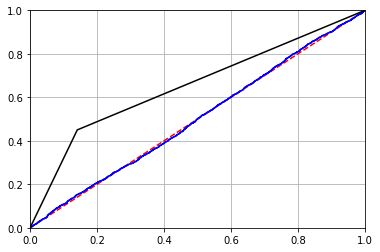

In [35]:
# Строим графики ROC AUC по вычисленным самостоятельно значениям и по значениям, полученным встроенным методом
plt.plot(fpr_1, tpr_1, color='red', linestyle='--')
plt.plot(fpr_2, tpr_2, color='blue', linestyle='-')
plt.plot(fpr_3, tpr_3, color='black')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

Из указнного выше графика видим, что качество третьей модели (RidgeClassifier) выше, чем у двух других (LassoCV и LogisticRegression). Качество же моделей LassoCV и LogisticRegression, согласно ROC AUC, примерно одинаковы.

In [36]:
# Строим PCA на подготовленных признаках
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-3.555946e+06,-7785.219682,-115.901406,9.276057,8.117791,-1.656652,5.938392,0.300004,0.396326,0.106159,...,8.284740e-10,3.574340e-09,1.698258e-09,-1.993587e-09,-2.062921e-09,1.939764e-09,-1.294136e-09,-4.473884e-09,1.662334e-09,-1.384810e-11
1,5.144707e+06,-6274.353602,-32.226421,-0.385692,-3.496653,8.622031,-0.986310,-0.832873,0.973957,-0.559272,...,-1.257950e-08,1.394332e-08,4.852598e-09,6.159452e-09,3.530198e-09,2.943095e-08,-6.723534e-09,6.535536e-09,-4.546246e-09,8.482584e-11
2,-3.656259e+06,-6154.348722,-91.680712,-1.434648,-1.250149,-2.062878,0.001545,0.851683,1.398185,-0.464076,...,1.537427e-09,-2.124964e-09,9.621104e-10,1.509063e-09,-3.132995e-10,1.020589e-09,3.172927e-09,-3.236517e-09,5.396877e-09,1.285334e-12
3,-3.556232e+06,-7354.681258,76.974247,-8.348071,1.180179,-1.894512,-1.395353,-1.176879,-0.145832,0.279091,...,-2.541399e-09,3.483577e-09,-2.873499e-09,-2.614908e-09,-9.905012e-10,-1.078644e-09,3.992536e-09,2.315413e-10,-1.419327e-09,-1.604285e-11
4,1.614382e+07,210.233837,116.556610,21.710235,4.195522,-5.643602,1.267492,1.389292,-0.315753,-0.118281,...,8.796875e-10,3.269462e-09,-7.257342e-10,-7.311906e-10,2.741206e-10,2.175065e-09,-1.100127e-09,6.803189e-12,-1.142023e-09,-2.084140e-11


In [37]:
# Изучим качество модели в зависимости от количества компонент
res = [[], []]
for i in range(1, 21):
    X2 = PCA(n_components=i*5).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3, random_state = 42)
    pca_model = RandomForestClassifier()
    pca_model.fit(X_train, y_train)
    res[0].append(i)
    res[1].append(pca_model.score(X_test, y_test))
pd.DataFrame({'Количество компонент': res[0], 
              'Качество модели': res[1]})

,Количество компонент,Качество модели
0,1,0.560571
1,2,0.649935
2,3,0.652659
3,4,0.648638
4,5,0.648249
5,6,0.647211
6,7,0.644228
7,8,0.643969
8,9,0.640726
9,10,0.641634


In [38]:
# Оределим дисперсию, вызванную каждым из основных компонентов. 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([9.99999450e-01, 5.50051755e-07, 1.30450608e-10, 5.08038050e-12,
       5.00351110e-13, 2.15461287e-13, 1.96564975e-13, 1.58303204e-14,
       5.16561344e-15, 2.65998761e-15, 2.48837395e-15, 2.26854086e-15,
       1.93549313e-15, 1.91389907e-15, 1.46798835e-15, 1.20909724e-15,
       1.03119841e-15, 9.77581976e-16, 9.35190764e-16, 8.91693466e-16,
       8.76420703e-16, 8.44363036e-16, 8.21838904e-16, 8.00820724e-16,
       7.27201400e-16, 7.05280072e-16, 6.85088523e-16, 6.67174319e-16,
       5.88474661e-16, 5.60823851e-16, 5.23512630e-16, 4.93607723e-16,
       4.62190506e-16, 4.32129954e-16, 3.95458026e-16, 3.84521548e-16,
       3.80315036e-16, 3.75258573e-16, 3.66090853e-16, 3.54215872e-16,
       3.45029742e-16, 3.37982247e-16, 3.33073112e-16, 3.30441722e-16,
       3.27294479e-16, 3.24199136e-16, 3.21334314e-16, 3.08901029e-16,
       3.05632535e-16, 2.84237553e-16, 2.78281384e-16, 2.70818478e-16,
       2.52915272e-16, 2.40701725e-16, 2.10939741e-16, 2.03219812e-16,
      